In [6]:
!pip install nltk wordcloud imbalanced-learn scikit-learn matplotlib gradio sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


feedback
0    14350
1     5820
Name: count, dtype: int64
Index(['Reviewer Name', 'Country', 'Review Count', 'Review Date', 'Rating',
       'Review Title', 'Review Text', 'feedback'],
      dtype='object')


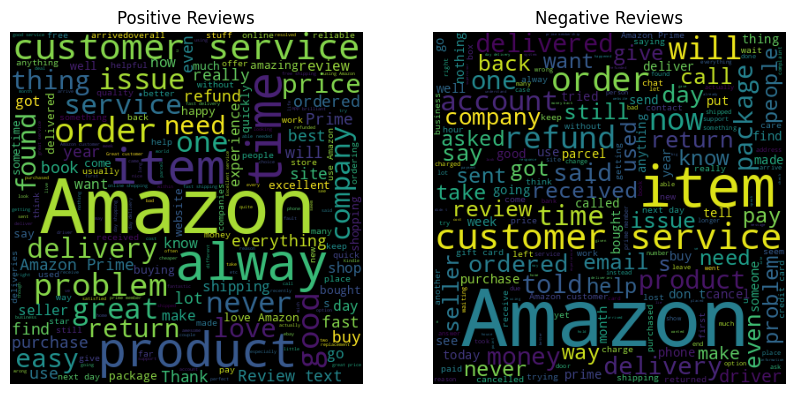

feedback
0    14350
1    14350
Name: count, dtype: int64


In [29]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from imblearn.over_sampling import RandomOverSampler

import pickle

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
# Download the missing punkt_tab resource
nltk.download('punkt_tab')
# Download the specific English averaged perceptron tagger
nltk.download('averaged_perceptron_tagger_eng')


df = pd.read_csv('Amazon_Reviews.csv')

extracted_rating = df['Rating'].str.extract(r'Rated (\d)')[0]
df['Rating'] = extracted_rating.astype('Int64')
df = df[df['Rating'] != 3]
df['feedback'] = df['Rating'].apply(lambda x: 1 if x >= 4 else 0)

print(df['feedback'].value_counts())


print(df.columns)

good_reviews = df[df['feedback'] == 1]['Review Text'].tolist()
bad_reviews = df[df['feedback'] == 0]['Review Text'].tolist()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(width=400, height=400).generate(' '.join(good_reviews)))
plt.title('Positive Reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(width=400, height=400).generate(' '.join(bad_reviews)))
plt.title('Negative Reviews')
plt.axis('off')

plt.show()


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [t.lower() for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    pos_tags = pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(tokens)


X = df['Review Text'].apply(preprocess_text)
y = df['feedback']

# Oversample minority class
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)
X_resampled = pd.Series(X_resampled.flatten())
y_resampled = pd.Series(y_resampled)

print(y_resampled.value_counts())

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, stratify=y_resampled, test_size=0.25, random_state=245
)


In [31]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=2000)
LR = LogisticRegression(C=2, max_iter=1000, n_jobs=-1)

pipeline = Pipeline([
    ('vectorizer', tfidf),
    ('classifier', LR)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3587
           1       0.94      0.94      0.94      3588

    accuracy                           0.94      7175
   macro avg       0.94      0.94      0.94      7175
weighted avg       0.94      0.94      0.94      7175



In [32]:
count_vec = CountVectorizer()
bnb = BernoulliNB()

pipeline_bnb = Pipeline([
    ('vectorizer', count_vec),
    ('classifier', bnb)
])

pipeline_bnb.fit(X_train, y_train)
y_pred_bnb = pipeline_bnb.predict(X_test)
print(classification_report(y_test, y_pred_bnb))


              precision    recall  f1-score   support

           0       0.90      0.73      0.81      3587
           1       0.77      0.91      0.84      3588

    accuracy                           0.82      7175
   macro avg       0.84      0.82      0.82      7175
weighted avg       0.84      0.82      0.82      7175



In [33]:
# Save
with open('sentiment_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# Load
with open('sentiment_pipeline.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)


In [34]:
def predict_sentiment(texts, model):
    if isinstance(texts, str):
        texts = [texts]
    processed = [preprocess_text(t) for t in texts]
    preds = model.predict(processed)
    return ['Positive' if p == 1 else 'Negative' for p in preds]

# Example usage:
test_texts = [
    "I love this product, it's amazing!",
    "Terrible experience, would not recommend."
]
print(predict_sentiment(test_texts, loaded_pipeline))


['Positive', 'Positive']


In [35]:
!pip install gradio


In [38]:
import gradio as gr

def gradio_predict(text, model_name):
    processed = preprocess_text(text)
    if model_name == "Logistic Regression":
        pred = pipeline.predict([processed])[0]
    elif model_name == "Bernoulli Naive Bayes":
        pred = pipeline_bnb.predict([processed])[0]
    else:
        return "Invalid model selected"
    return "Positive 😊" if pred == 1 else "Negative 😞"

model_options = ["Logistic Regression", "Bernoulli Naive Bayes"]

interface = gr.Interface(
    fn=gradio_predict,
    inputs=[
        gr.Textbox(lines=3, placeholder="Enter a review here..."),
        gr.Dropdown(choices=model_options, label="Select Model")
    ],
    outputs="text",
    title="Sentiment Analyzer",
    description="Enter a review and select the model to predict sentiment."
)

interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4923f055658f2d6b38.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
